## Lab: RNN with Forecasting

### Wind Turbine Power Prediction with RNN

This lab uses a Recurrent Neural Network to predict wind turbine power output.
* [Data link](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)

### Step 0: Load libraries & Data

In [1]:
# ----- Step 0: Load libraries & Data -----

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math
import os
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the data
csv_path = "T1.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}")

try:
    df = pd.read_csv(csv_path)
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding="utf-8-sig")

In [2]:
# Display the first 5 rows of the dataset
# Confirm shape and preview
print("Shape:", df.shape)
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset structure and column information
print("\nDataset info:")
print(df.info())

# Display the number of missing values per column
print("\nMissing values in each column:")
print(df.isnull().sum())

# Display basic statistics for numerical columns
print("\nStatistical summary of the dataset:")
print(df.describe())

Shape: (50530, 5)
First 5 rows of the dataset:
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Da

### Step 1: Prepare the data


Missing values BEFORE handling:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

Missing values AFTER handling:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
dtype: int64

Summary statistics (cleaned):
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)
count         50530.000000      50530.000000                   50530.000000
mean           1307.684332          7.557952                    1492.175463
std            1312.459242          4.227166                    1368.018238
min              -2.471405          0.000000                       0.000000
25%              50.677890          4.201395                     161.328167
50%             825.838074          7.104594                    1063.776283
75%            2482.507568     

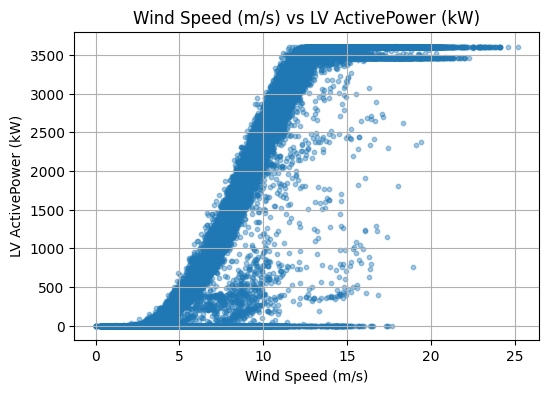


Scaled data shape: (50530, 3)
First 5 rows of scaled data:
            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00             0.105633          0.210717   
1 2018-01-01 00:10:00             0.125991          0.225032   
2 2018-01-01 00:20:00             0.085289          0.206936   
3 2018-01-01 00:30:00             0.116568          0.224537   
4 2018-01-01 00:40:00             0.105800          0.221294   

   Theoretical_Power_Curve (KWh)  
0                       0.115647  
1                       0.144422  
2                       0.108583  
3                       0.143369  
4                       0.136584  


In [3]:
# ----- Step 1: Prepare the Data -----

# 1) Date/Time -> datetime and sort
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%d %m %Y %H:%M", errors="raise")
df = df.sort_values("Date/Time").drop_duplicates("Date/Time").reset_index(drop=True)

# 2) Handle missing values (time-series friendly)
print("\nMissing values BEFORE handling:")
print(df.isnull().sum())

feature_cols = ["LV ActivePower (kW)", "Wind Speed (m/s)", "Theoretical_Power_Curve (KWh)"]

# Interpolate numeric features over time; then drop any stragglers in key cols
df = df.set_index("Date/Time")
df[feature_cols] = df[feature_cols].interpolate(method="time", limit_direction="both")
df = df.reset_index()
df = df.dropna(subset=feature_cols)

print("\nMissing values AFTER handling:")
print(df[["Date/Time"] + feature_cols].isnull().sum())

# 3) Basic EDA
print("\nSummary statistics (cleaned):")
print(df[feature_cols].describe())

plt.figure(figsize=(6, 4))
plt.scatter(df["Wind Speed (m/s)"], df["LV ActivePower (kW)"], alpha=0.4, s=10)
plt.title("Wind Speed (m/s) vs LV ActivePower (kW)")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("LV ActivePower (kW)")
plt.grid(True)
plt.show()

# 4) Select & Normalize features
features = df[feature_cols].copy()

# NOTE: For modeling later, fit the scaler on TRAIN ONLY to avoid leakage.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vals = scaler.fit_transform(features.values)

scaled_df = pd.DataFrame(scaled_vals, columns=feature_cols, index=df.index)
scaled_df.insert(0, "Date/Time", df["Date/Time"].values)

print("\nScaled data shape:", scaled_vals.shape)
print("First 5 rows of scaled data:")
print(scaled_df.head())

### Step 2: Create sequences

In [4]:
# ----- Step 2: Create Sequences  -----

import numpy as np

def create_sequences(data: np.ndarray, seq_length: int = 24, target_col: int = 0):
    """
    Build sliding-window sequences for one-step-ahead forecasting.

    Parameters
    ----------
    data : np.ndarray
        Scaled array of shape (T, F) where T is timesteps and F is number of features.
    seq_length : int
        Number of time steps in each input window.
    target_col : int
        Index of the target column in `data` (0 if 'LV ActivePower (kW)' is first).

    Returns
    -------
    X : np.ndarray
        Shape (num_samples, seq_length, F), dtype float32.
    y : np.ndarray
        Shape (num_samples,), dtype float32.
    """
    # Ensure float32 dtype (preferred by Keras)
    if not isinstance(data, np.ndarray):
        data = np.asarray(data, dtype=np.float32)
    else:
        data = data.astype(np.float32, copy=False)

    # Basic validations
    if np.isnan(data).any():
        raise ValueError("Input `data` contains NaN. Clean or impute before sequencing.")
    if seq_length < 1 or len(data) <= seq_length:
        raise ValueError(f"seq_length={seq_length} is invalid for data length {len(data)}.")

    X, y = [], []
    T = len(data)
    # For each position, take a window [i : i+seq_length] as X and the next step as y
    for i in range(T - seq_length):
        X.append(data[i:i+seq_length, :])          # window of features
        y.append(data[i+seq_length, target_col])   # next-step target

    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    return X, y


# ----- Configuration -----
# Choose sequence length (e.g., 24 = 4 hours if the sampling step is 10 minutes)
seq_length = 24
target_col = 0  # 0 if 'LV ActivePower (kW)' is the first column in your feature set

# ----- Build `scaled_data` from Step 1 artifacts -----
# Prefer the no-leakage array `scaled_all` if you followed the train-only fit pattern.
if 'scaled_all' in globals():
    scaled_data = np.asarray(scaled_all, dtype=np.float32)
elif 'scaled_df' in globals() and 'feature_cols' in globals():
    scaled_data = scaled_df[feature_cols].values.astype(np.float32)
elif 'scaled_vals' in globals():
    scaled_data = scaled_vals.astype(np.float32)
else:
    raise NameError(
        "No scaled data found. Run Step 1 to create one of: "
        "`scaled_all` (no-leakage pattern) or `scaled_df`/`scaled_vals`."
    )

# ----- Sanity checks on the scaled array -----
assert scaled_data.ndim == 2, "scaled_data must be 2D (T, F)."
assert len(scaled_data) > seq_length, "seq_length must be smaller than data length."
assert not np.isnan(scaled_data).any(), "scaled_data contains NaN — clean/impute before sequencing."

# ----- Create sequences -----
X, y = create_sequences(scaled_data, seq_length=seq_length, target_col=target_col)

# ----- Shape checks -----
print("X shape:", X.shape)  # expected: (num_samples, seq_length, num_features)
print("y shape:", y.shape)  # expected: (num_samples,)
num_features = X.shape[2]
print("num_features:", num_features)

# ----- (Optional) Align targets to timestamps for later plotting/splitting -----
# Works if Step 1 created df["Date/Time"] as a proper datetime column.
if 'df' in globals() and "Date/Time" in df.columns:
    try:
        target_timestamps = df["Date/Time"].iloc[seq_length: seq_length + len(y)].values
        print("First target timestamp:", target_timestamps[0])
        print("Last  target timestamp:", target_timestamps[-1])
    except Exception as e:
        print("Timestamp alignment skipped:", e)



X shape: (50506, 24, 3)
y shape: (50506,)
num_features: 3
First target timestamp: 2018-01-01T04:00:00.000000000
Last  target timestamp: 2018-12-31T23:50:00.000000000


### Step 3: Split the data

In [5]:
# ----- Step 3: Split the Data (chronological 80/20) -----

# Assumes X, y, and seq_length are already defined in Step 2
train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing

# For time series: keep chronological order (no shuffling)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Shape sanity checks
print("X_train shape:", X_train.shape)  # (num_train, seq_length, num_features)
print("y_train shape:", y_train.shape)  # (num_train,)
print("X_test shape:",  X_test.shape)   # (num_test, seq_length, num_features)
print("y_test shape:",  y_test.shape)   # (num_test,)

# Optional consistency assertions
assert X_train.shape[0] == y_train.shape[0], "Train X/y length mismatch"
assert X_test.shape[0]  == y_test.shape[0],  "Test X/y length mismatch"
assert X_train.shape[1] == seq_length == X_test.shape[1], "Unexpected sequence length"

num_features = X_train.shape[2]
print("num_features:", num_features)

# (Optional) Inspect target time ranges; requires df with 'Date/Time' from Step 1
# target_timestamps = df.loc[seq_length:, "Date/Time"].values
# print("Train period:", target_timestamps[0], "→", target_timestamps[train_size - 1])
# print("Test  period:", target_timestamps[train_size], "→", target_timestamps[-1])

X_train shape: (40404, 24, 3)
y_train shape: (40404,)
X_test shape: (10102, 24, 3)
y_test shape: (10102,)
num_features: 3


### Step 4: Build the RNN Model

In [6]:
# ----- Step 4: Build the RNN (LSTM) model -----

# Optional: clear any previous graph to avoid clutter when re-running cells
tf.keras.backend.clear_session()

# Ensure training arrays are float32 (LSTM prefers float32 tensors)
X_train = X_train.astype("float32", copy=False)
y_train = y_train.astype("float32", copy=False)
X_test  = X_test.astype("float32",  copy=False)
y_test  = y_test.astype("float32",  copy=False)

seq_len = X_train.shape[1]
n_features = X_train.shape[2]

# Define a stacked LSTM model for one-step-ahead regression
model = Sequential([
    # First LSTM: returns full sequences so the next LSTM can process them
    LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)),
    Dropout(0.2),
    # Second (top) LSTM: returns last hidden state only
    LSTM(32),
    Dropout(0.2),
    # Final regression head (1 unit for a single target)
    Dense(1)
])

# Compile with Adam optimizer and MSE loss; MAE as an additional metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="mean_squared_error",
              metrics=["mae"])

# Print architecture summary (recommended)
model.summary()

/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the model

Available GPUs: []
Epoch 1/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0454 - mae: 0.1397
Epoch 1: val_loss improved from None to 0.01025, saving model to best_lstm.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0235 - mae: 0.0983 - val_loss: 0.0102 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 2/50
284/285 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169 - mae: 0.0848
Epoch 2: val_loss improved from 0.01025 to 0.00796, saving model to best_lstm.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0135 - mae: 0.0736 - val_loss: 0.0080 - val_mae: 0.0638 - learning_rate: 0.0010
Epoch 3/50
281/285 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0128 - mae: 0.0729
Epoch 3: val_loss improved from 0.00796 to 0.00714, saving model to best_lstm.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0105 - mae: 0.0643 - val_loss: 0.0071 - val_mae: 0.0611 - learning_rate: 0.0010
Epoch 4/50
284/285 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - mae: 0.0655
Epoch 4:

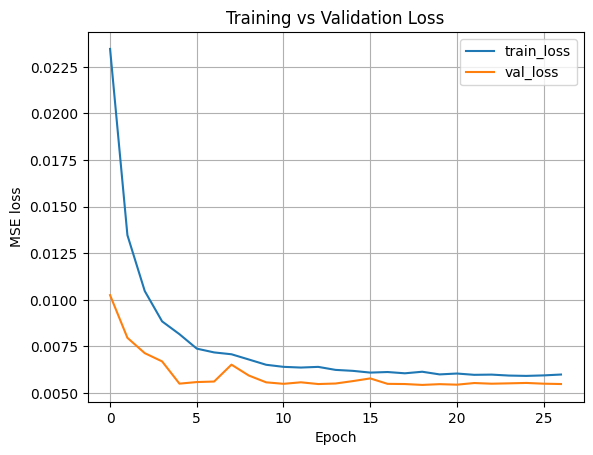

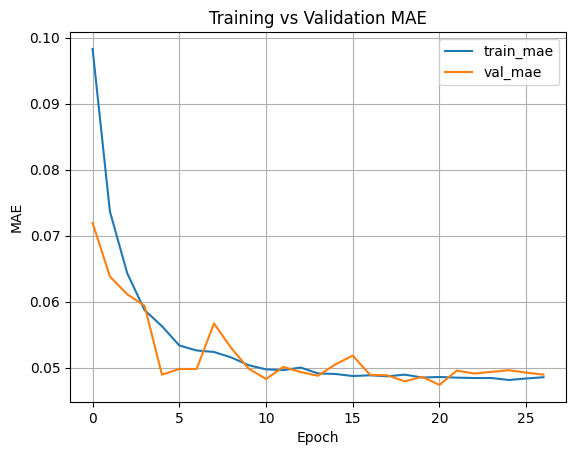

In [7]:
# ----- Step 5: Train the model -----

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping to avoid overfitting (restore best weights by val_loss)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Reduce LR when validation plateaus (optional but useful)
lr_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

# Save the best full model (.keras format = arch + weights)
ckpt_path = "best_lstm.keras"
checkpoint = ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

print("Available GPUs:", tf.config.list_physical_devices("GPU"))

# Validation split uses the LAST 10% of X_train chronologically (shuffle=False keeps order)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, lr_plateau, checkpoint],
    verbose=1,
    shuffle=False
)

# Plot training curves (Loss)
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE if available
if "mae" in history.history:
    plt.figure()
    plt.plot(history.history["mae"], label="train_mae")
    if "val_mae" in history.history:
        plt.plot(history.history["val_mae"], label="val_mae")
    plt.title("Training vs Validation MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()

### Step 6: Evaluate on the test data and visualize the results

Test MAE : 138.427 kW
Test RMSE: 231.442 kW
Test R^2 : 0.9703
Baseline (persistence) RMSE: 228.452 kW


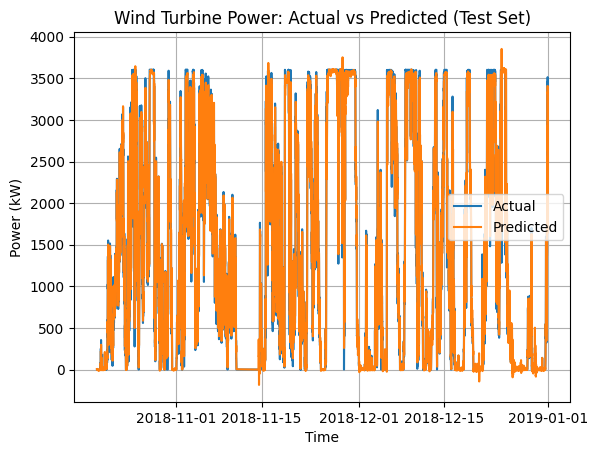

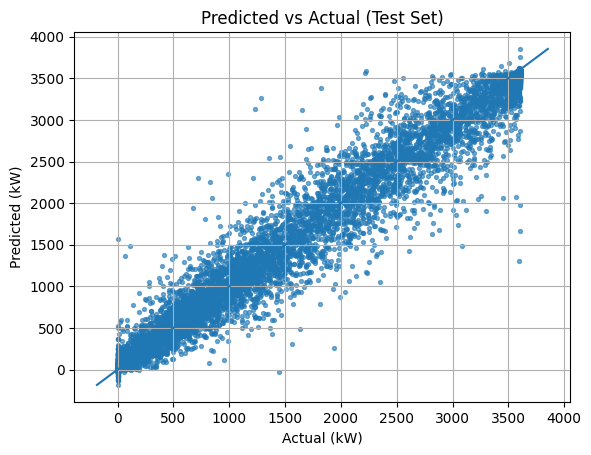

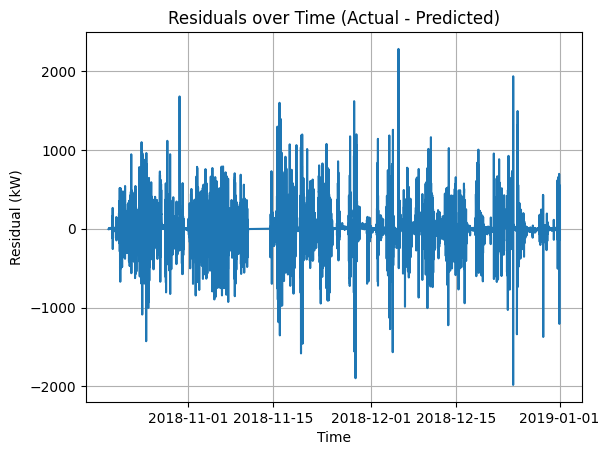

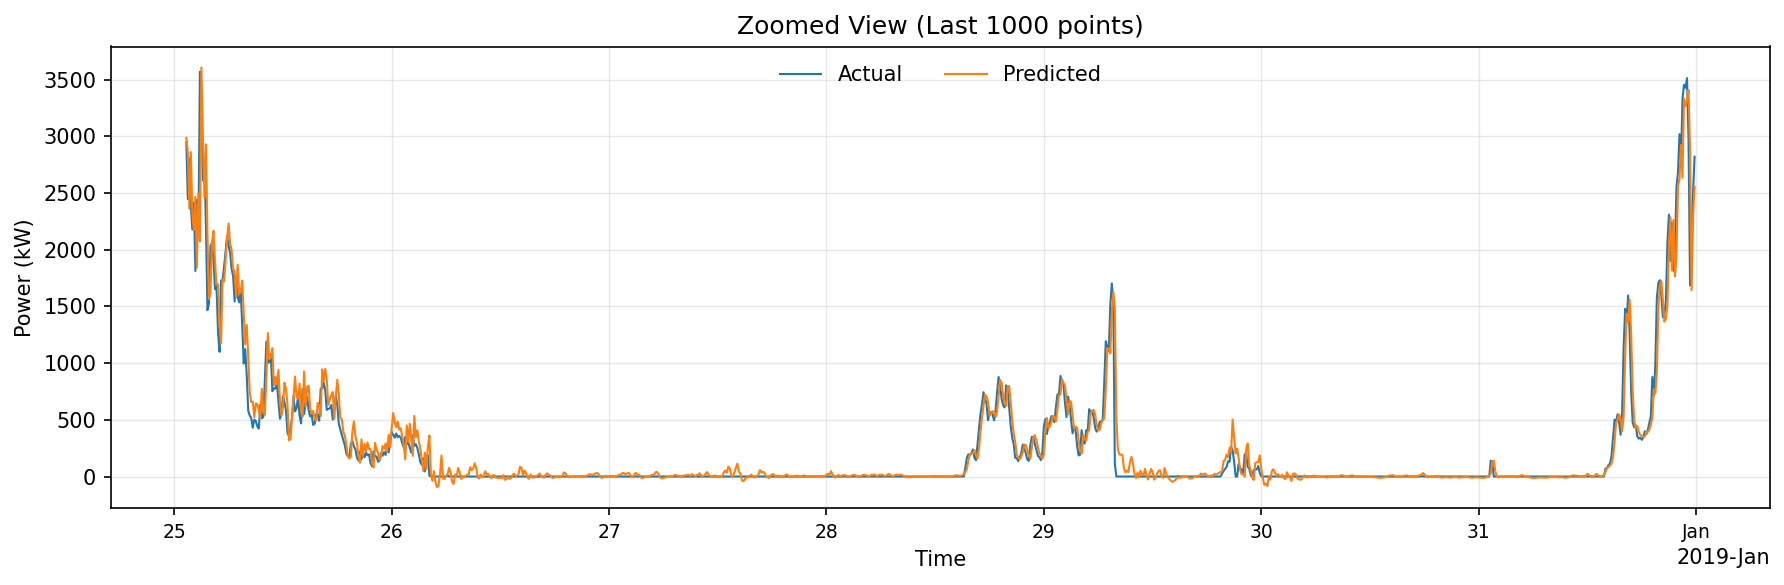

In [8]:
# ----- Step 6: Evaluate on the test data and visualize results -----

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.dates as mdates

def inverse_scale_target(scaled_vector, scaler, target_col=0, n_features=None):
    """
    Inverse-scale a single target column using the same MinMaxScaler that was fit on all features.
    scaled_vector : (N,) or (N,1) array in scaled space
    scaler       : fitted MinMaxScaler
    target_col   : index of the target feature in scaler feature space
    n_features   : total number of features the scaler was fit on (defaults to scaler.n_features_in_)
    """
    sv = np.asarray(scaled_vector).reshape(-1, 1).astype(np.float32)
    if n_features is None:
        # robust default in case the code path changed variable names
        n_features = getattr(scaler, "n_features_in_", scaler.scale_.shape[0])

    # Create a temporary feature matrix, place the target in its column, zeros elsewhere
    temp = np.zeros((len(sv), n_features), dtype=np.float32)
    temp[:, target_col] = sv.ravel()

    inv = scaler.inverse_transform(temp)
    return inv[:, target_col]

# 1) Predict in scaled space
y_pred_scaled = model.predict(X_test, verbose=0).ravel()

# 2) Inverse-scale predictions and ground truth back to original units (kW)
target_col = 0
n_features = getattr(scaler, "n_features_in_", None)

y_pred = inverse_scale_target(y_pred_scaled, scaler, target_col=target_col, n_features=n_features)
y_true = inverse_scale_target(y_test,         scaler, target_col=target_col, n_features=n_features)

# 3) Metrics in original units
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
r2   = r2_score(y_true, y_pred)

print(f"Test MAE : {mae:,.3f} kW")
print(f"Test RMSE: {rmse:,.3f} kW")
print(f"Test R^2 : {r2:,.4f}")

# Optional baseline: persistence (predict the previous actual)
if len(y_true) > 1:
    y_true_shifted = y_true[1:]
    y_persist = y_true[:-1]
    rmse_persist = math.sqrt(mean_squared_error(y_true_shifted, y_persist))
    print(f"Baseline (persistence) RMSE: {rmse_persist:,.3f} kW")

# 4) Build a DateTime index for the test targets
# Targets start after the initial seq_length warmup; test set starts at 'train_size' samples into (X, y)
test_start = seq_length + train_size
test_end   = test_start + len(y_test)  # exclusive
test_timestamps = df["Date/Time"].iloc[test_start:test_end].values  # DatetimeIndex values

# Assemble results DataFrame
results = pd.DataFrame(
    {"Actual_kW": y_true, "Pred_kW": y_pred},
    index=pd.to_datetime(test_timestamps)
)
results.index.name = "Date/Time"
results["Residual_kW"] = results["Actual_kW"] - results["Pred_kW"]

# 5) Plots
# Time-series: full test segment
plt.figure()
plt.plot(results.index, results["Actual_kW"], label="Actual")
plt.plot(results.index, results["Pred_kW"], label="Predicted")
plt.title("Wind Turbine Power: Actual vs Predicted (Test Set)")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.grid(True)
plt.show()

# Scatter: Predicted vs Actual with y=x reference
lims = [
    min(results["Actual_kW"].min(), results["Pred_kW"].min()),
    max(results["Actual_kW"].max(), results["Pred_kW"].max())
]
plt.figure()
plt.scatter(results["Actual_kW"], results["Pred_kW"], s=8, alpha=0.6)
plt.plot(lims, lims)  # y = x
plt.title("Predicted vs Actual (Test Set)")
plt.xlabel("Actual (kW)")
plt.ylabel("Predicted (kW)")
plt.grid(True)
plt.show()

# Residuals over time
plt.figure()
plt.plot(results.index, results["Residual_kW"])
plt.title("Residuals over Time (Actual - Predicted)")
plt.xlabel("Time")
plt.ylabel("Residual (kW)")
plt.grid(True)
plt.show()

# --- Zoom window (suggestion) ---
window = 1000  # adjust as needed
zoom = results.iloc[-window:] if len(results) > window else results.copy()

fig, ax = plt.subplots(figsize=(12, 4), dpi=150)

ax.plot(zoom.index, zoom["Actual_kW"], label="Actual", linewidth=1.0)
ax.plot(zoom.index, zoom["Pred_kW"],   label="Predicted", linewidth=1.0)

# --- Make the time axis pretty ---
# Fewer, smarter ticks + concise labels
locator   = mdates.AutoDateLocator(minticks=5, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


ax.tick_params(axis='x', labelrotation=0, labelsize=9)

# Cosmetics
ax.set_title(f"Zoomed View (Last {len(zoom)} points)")
ax.set_xlabel("Time")
ax.set_ylabel("Power (kW)")
ax.grid(True, linewidth=0.6, alpha=0.3)
ax.legend(frameon=False, ncol=2, loc="best")

fig.tight_layout()
plt.show()